In [1031]:
import math
import pickle
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
from matplotlib.animation import FuncAnimation
from constants import *
from EOS import set_eos
import background as bk
from RK import rk3_step, rk4_step
from Eq_timeD import rhs_perturb, set_initial_data, H_constraint
import os
from sys import exit
import pandas as pd

In [890]:
#eos: Equations of state data
#pc: pressure at the center
#Nrf: Nrf * radius establishes the final radius of the grid
#nt: Number of points of temporal grid
#CFL: Courant–Friedrichs–Lewy condition
#l: Indicate degree of the function
#index_IC: Defines which initial condition will be used
#Nr0: Nr0 * radius establishes the radius where the Gaussian is centered
#Nsigma: Nsigma * radius establishes the Gaussian diameter
#Nsave: Space a list by saving one data for each Nsave points
#Nrobs: Nrobs * radius where the observer is located.

### INPUTS

In [1058]:
eos = "apr.csv"
pc = 5
nr_int = 400
Nrf = 100
nt = 60000 
CFL = 0.6
l = 2
index_IC = 1
Nr0 = 10
Nsigma = 1
Nsave = 20
Nrobs = 10

### SOLVING FOR THE BACKGROUND


In [1059]:
file_eos = eos
ep_eos = set_eos(file_eos)[0]
cs2_eos = set_eos(file_eos)[2] # cs2 as a function of energy density
soltov = bk.solve_TOV(file_eos, pc, dr_TOV)

r_aux = soltov[-1][-1]
radius = soltov[0]
mass = soltov[1]
radius_KM = soltov[0] * (LightC / (NewtonG * rho_dim) ** (1/2) * 10**(-5))
mass_MS = soltov[1] * (rho_dim * (LightC / (NewtonG * rho_dim) ** (1/2))**3 ) / (MSun)

#print("Number of points inside star (background):", math.floor(radius/dr_TOV))

lamb_interp = interp1d(np.append(soltov[-1],[radius]), np.append(soltov[2],[math.log(1/(1-2*mass/radius))]), bounds_error=False)
nu_interp = interp1d(np.append(soltov[-1],[radius]), np.append(soltov[3],[math.log(1-2*mass/radius)]), bounds_error=False)
p_interp = interp1d(np.append(soltov[-1],[radius]), np.append(soltov[4],[10**(-16)]), bounds_error=False)

def bkg_func (r):
    if r < radius:
        return lamb_interp(r), (r/2) * (1 - math.exp(-lamb_interp(r))) , nu_interp(r), p_interp(r), ep_eos(p_interp(r)), cs2_eos(ep_eos(p_interp(r)))
    elif r >= radius:
        return math.log(1/(1-2*mass/r)), mass, math.log(1-2*mass/r), 0, 0, cs2_eos(ep_eos(p_interp(radius)))


print("Radius (Km):", radius_KM)
print("Mass (MSun):", mass_MS)

Radius (Km): 10.223026890542217
Mass (MSun): 2.153880812506455


### DEFINING GRID

In [1060]:
ri = ri_TOV
rf = Nrf * radius
dr = ((radius - ri) / (nr_int - 1))

r = np.arange(ri, rf, dr)

nr = len(r)
dt = CFL * dr

### DEFINING ARRAYS OF BACKGROUND QUANTITIES

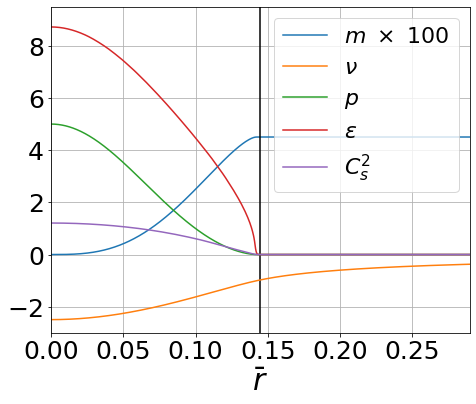

In [1061]:
%matplotlib inline

lamb = []
m = []
nu = []
p = []
rho = []
cs2 = []

for i in range(nr):
    aux = bkg_func(r[i])
    lamb.append(aux[0])
    m.append(aux[1])
    nu.append(aux[2])
    p.append(aux[3])
    rho.append(aux[4])
    cs2.append(aux[5])

# Ploting background functions

m100 = []
for i in range(len(m)):
    m100.append(m[i] * 100)

plt.figure(figsize=(7.5,6))
plt.grid()
plt.plot(r, m100, label=r"$m \ \times \ 100$")
plt.plot([radius,radius], [-5,20], color="black")
plt.plot(r, nu, label=r"$\nu$")
plt.plot(r, p, label=r"$p$")
plt.plot(r, rho, label=r"$\epsilon$")
plt.plot(r, cs2, label=r"$C_s^2$")
plt.xlabel(r"$\bar{r}$", fontsize=30)
plt.xlim(0, 2 * radius)
plt.ylim(-3, 9.5)
plt.legend()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=22)

#plt.savefig("bkg.png")

### SETTING INITIAL CONDITIONS

In [1062]:
sigma = Nsigma * radius
r0 = Nr0 * radius

if index_IC == 1:
    uin = set_initial_data(1, r, radius, r0, sigma, l, bkg_func)
if index_IC == 2:
    uin = set_initial_data(2, r, radius, 0, 0, l, bkg_func)

S = uin.T[0]
F = uin.T[2]
H = uin.T[4]

Sevol = np.empty((math.floor(nt / Nsave), nr))
Sevol[0] = S
Fevol = np.empty((math.floor(nt / Nsave), nr))
Fevol[0] = F
Hevol = np.empty((math.floor(nt / Nsave), nr))
Hevol[0] = H
Hamiltevol = np.empty((math.floor(nt / Nsave), nr))
Hamiltevol[0] = H_constraint(uin, l, lamb, m, nu, p, rho, cs2, r, nr_int).T[0]

print("Maximum violation of Hamiltonian constraint:", max(Hamiltevol[0]))

robs = Nrobs * radius

nr_obs = min(range(len(r)), key=lambda i: abs(r[i]-robs))  #index

Sobs = np.empty(nt+1)
Sobs[0] = S[nr_obs]
Fobs = np.empty(nt+1)
Fobs[0] = F[nr_obs]
Hobs = np.empty(nt+1)
Hobs[0] = H[nr_obs]

Maximum violation of Hamiltonian constraint: 0.00021803286869115368


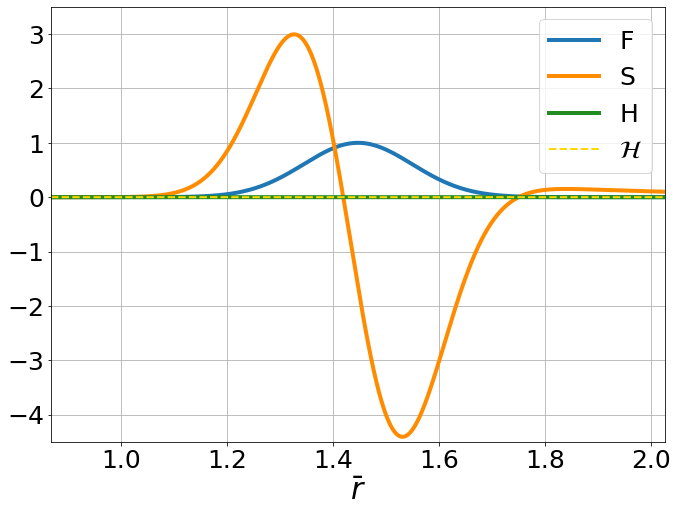

In [1063]:
# Ploting the initial conditions

%matplotlib inline

plt.figure(figsize=(11,8))
#plt.figure()
plt.grid()
plt.plot(r, F, label="F", linewidth = 4)
plt.plot(r, S, label="S", linewidth = 4, color="darkorange")
plt.plot(r, H, label="H", linewidth = 4, color="forestgreen")
plt.plot(r, Hamiltevol[0],'--', label = r"$\mathcal{H}$", linewidth=2, color='gold')
if index_IC == 1:
    plt.xlim(r0 - 4 * sigma, r0 + 4 * sigma)
    plt.ylim(-4.5, 3.5)
if index_IC == 2:
    plt.xlim(0, 2* radius)

ax = plt.gca()
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
ax.set_xlabel(r'$\bar{r}$', fontsize=30)
plt.legend(fontsize=25)

#plt.savefig("CI_2.pdf")

#plt.close()  # Prevent plot from showing in jupyter notebook

### EVOLVING PERTURBATIONS EQUATIONS

In [902]:
u = np.copy(uin)
uaux = np.copy(uin)

for n in range(nt):
    uaux = rk3_step(n * dt, u, dt, rhs_perturb, l, lamb, m, nu, p, rho, cs2, r)
    for i in range(n_special):  # Adjusting behavior around r = 0
        uaux.T[0][i] = uaux.T[0][n_special] * (r[i] / r[n_special]) ** (l + 1)
        uaux.T[2][i] = uaux.T[2][n_special] * (r[i] / r[n_special]) ** (l + 1)
        uaux.T[4][i] = uaux.T[4][n_special] * (r[i] / r[n_special]) ** l

    # Parar a evolução caso haja divergências:
    if np.any(np.isnan(uaux)):
        break
    # Atualiza o próprio u se não há divergências:
    u = uaux

    # Guarda o valor de S, F, H e Hamilt a cada Nsave passos
    if (n + 1) % Nsave == 0:
        Sevol[math.floor(n / Nsave)] = u.T[0]
        Fevol[math.floor(n / Nsave)] = u.T[2]
        Hevol[math.floor(n / Nsave)] = u.T[4]
        Hamiltevol[math.floor(n / Nsave)] = H_constraint(u, l, lamb, m, nu, p, rho, cs2, r, nr_int).T[0]

    # Guarda o valor de S, F e H no r_obs:
    Sobs[n + 1] = u.T[0][nr_obs]
    Fobs[n + 1] = u.T[2][nr_obs]
    Hobs[n + 1] = u.T[4][nr_obs]

robs = [Sobs, Fobs, Hobs]

In [922]:
# Criando dados

#Sobs_400 = pd.DataFrame(Sobs)
#Fobs_400 = pd.DataFrame(Fobs)
#Hobs_400 = pd.DataFrame(Hobs)
#Sevol_400 = pd.DataFrame(Sevol)
#Fevol_400 = pd.DataFrame(Fevol)
#Hevol_400 = pd.DataFrame(Hevol)
#Hamiltevol_400 = pd.DataFrame(Hamiltevol)
#dt_400 = dt 

#with pd.HDFStore('dados400_dt.dat', mode='w') as store:
#    store['Sobs_400'] = Sobs_400
#    store['Fobs_400'] = Fobs_400
#    store['Hobs_400'] = Hobs_400    
#    store['Sevol_400'] = Sevol_400
#    store['Fevol_400'] = Fevol_400
#    store['Hevol_400'] = Hevol_400
#    store['Hamiltevol_400'] = Hamiltevol_400
#    dt_400 = pd.DataFrame({'dt_400': [dt_400]})
#    store['dt_400'] = dt_400

### Importing data

In [1544]:
# importando dados 50

with pd.HDFStore('dados50.dat', mode='r') as store:
    Sobs_50 = store['Sobs_50']
    Fobs_50 = store['Fobs_50']
    Hobs_50 = store['Hobs_50']
    Sevol_50 = store['Sevol_50']
    Fevol_50 = store['Fevol_50']
    Hevol_50 = store['Hevol_50']
    Hamiltevol_50 = store['Hamiltevol_50']
    dt_50 = store['dt_50'] 

Sobs50 = Sobs_50.to_numpy()    
Fobs50 = Fobs_50.to_numpy()    
Hobs50 = Hobs_50.to_numpy()    
Sevol50 = Sevol_50.to_numpy()
Fevol50 = Fevol_50.to_numpy()
Hevol50 = Hevol_50.to_numpy()
Hamiltevol50 = Hamiltevol_50.to_numpy()
dt50 = dt_50['dt_50'].values[0]

In [1535]:
# importando dados 100

with pd.HDFStore('dados100.dat', mode='r') as store:
    Sobs_100 = store['Sobs_100']
    Fobs_100 = store['Fobs_100']
    Hobs_100 = store['Hobs_100']
    Sevol_100 = store['Sevol_100']
    Fevol_100 = store['Fevol_100']
    Hevol_100 = store['Hevol_100']
    Hamiltevol_100 = store['Hamiltevol_100']
    dt_100 = store['dt_100'] 

Sobs100 = Sobs_100.to_numpy()    
Fobs100 = Fobs_100.to_numpy()    
Hobs100 = Hobs_100.to_numpy()    
Sevo100 = Sevol_100.to_numpy()
Fevol100 = Fevol_100.to_numpy()
Hevol100 = Hevol_100.to_numpy()
Hamiltevol100 = Hamiltevol_100.to_numpy()
dt100 = dt_100['dt_100'].values[0]

In [1533]:
# importando dados 200

with pd.HDFStore('dados200.dat', mode='r') as store:
    Sobs_200 = store['Sobs_200']
    Fobs_200 = store['Fobs_200']
    Hobs_200 = store['Hobs_200']
    Sevol_200 = store['Sevol_200']
    Fevol_200 = store['Fevol_200']
    Hevol_200 = store['Hevol_200']
    Hamiltevol_200 = store['Hamiltevol_200']
    dt_200 = store['dt_200'] 

Sobs200 = Sobs_200.to_numpy()    
Fobs200 = Fobs_200.to_numpy()    
Hobs200 = Hobs_200.to_numpy()    
Sevo200 = Sevol_200.to_numpy()
Fevol200 = Fevol_200.to_numpy()
Hevol200 = Hevol_200.to_numpy()
Hamiltevol200 = Hamiltevol_200.to_numpy()
dt200 = dt_200['dt_200'].values[0]

In [1588]:
# importando dados 400

with pd.HDFStore('dados400_dt.dat', mode='r') as store:
    Sobs_400 = store['Sobs_400']
    Fobs_400 = store['Fobs_400']
    Hobs_400 = store['Hobs_400']
    Sevol_400 = store['Sevol_400']
    Fevol_400 = store['Fevol_400']
    Hevol_400 = store['Hevol_400']
    Hamiltevol_400 = store['Hamiltevol_400']
    dt_400 = store['dt_400'] 

Sobs400 = Sobs_400.to_numpy()    
Fobs400 = Fobs_400.to_numpy()    
Hobs400 = Hobs_400.to_numpy()    
Sevol400 = Sevol_400.to_numpy()
Fevol400 = Fevol_400.to_numpy()
Hevol400 = Hevol_400.to_numpy()
Hamiltevol400 = Hamiltevol_400.to_numpy()
dt400 = dt_400['dt_400'].values[0]

### GENERETING THE ANIMATION

<IPython.core.display.Javascript object>


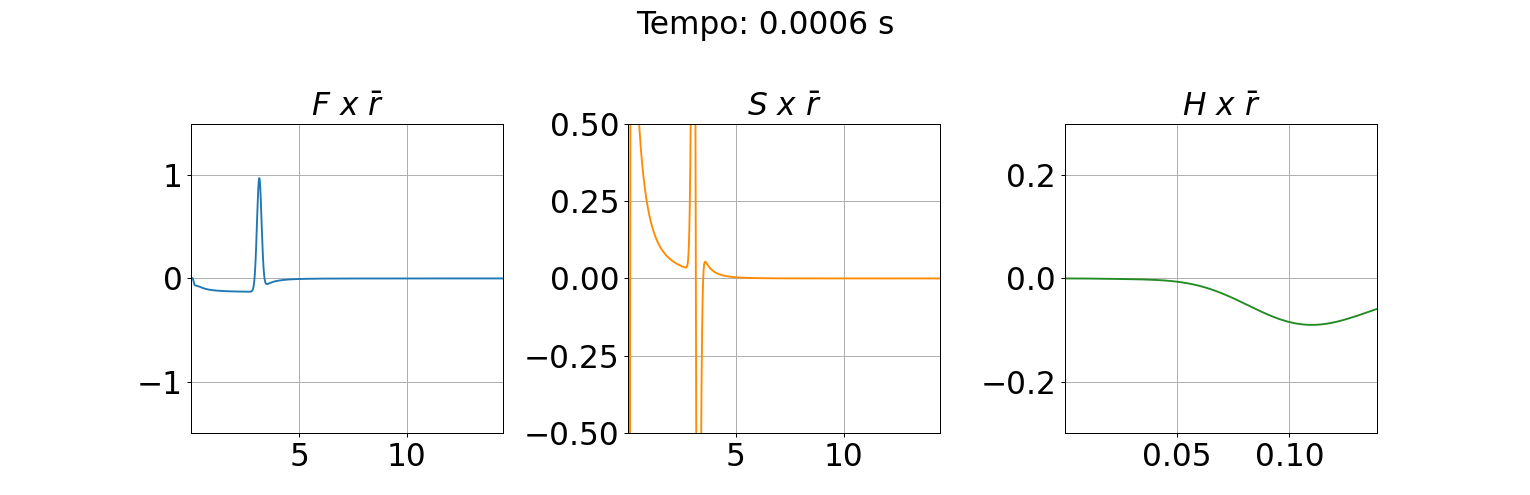

In [1531]:
%matplotlib notebook

N_plots = int(nt / Nsave)

fig, (axF, axS, axH) = plt.subplots(1, 3, gridspec_kw={'hspace': 0.4, 'wspace': 0.4}, figsize=(17,5.5))

font_size = 25

graphF, = axF.plot([], [])
graphS, = axS.plot([], [])
graphH, = axH.plot([], [])
axF.set_ylim(-1.5, 1.5)
axF.set_xlim(ri, rf)
axF.grid()
axS.set_ylim(-0.5, 0.5)
axS.set_xlim(ri, rf)
axS.grid()
axH.set_ylim(-0.3, 0.3)
axH.set_xlim(ri, 0.96*radius)
axH.grid()
axH.set_title(r'$H \ x \ \bar{r}$', fontsize = font_size)
axF.set_title(r'$F \ x \ \bar{r}$', fontsize = font_size)
axS.set_title(r'$S\ x \ \bar{r}$', fontsize = font_size)
title = fig.suptitle("Tempo: 0.0000 s", fontsize=font_size)
plt.subplots_adjust(top=0.75)

axF.tick_params(axis='both', which='major', labelsize=font_size)
axS.tick_params(axis='both', which='major', labelsize=font_size)
axH.tick_params(axis='both', which='major', labelsize=font_size)

def animate(i):
    graphF.set_data(r, Fevol400[i])
    graphS.set_data(r, Sevol400[i])
    graphH.set_data(r, Hevol400[i])
    #graphHamilt.set_data(r, Hamiltevol[i])
    graphS.set_color("darkorange")
    graphH.set_color("forestgreen")
    title.set_text('Tempo: ' + str(round(dt + i * dt * Nsave / (((NewtonG * rho_dim) ** (1 / 2) )), 4)) + ' s')
    return graphF, graphS, graphH, title #graphHamilt, title

ani = FuncAnimation(fig, animate, frames=N_plots, interval=2)

### AVERAGE VALUE OF THE HAMILTONIAN

In [1556]:
%matplotlib inline

N_plots_50 = len(Fevol50)
N_plots_100 = len(Fevol100)
N_plots_200 = len(Fevol200)
N_plots_400 = len(Fevol400)

LnormH_50 = []
t_50 = []
LnormH_100 = []
t_100 = []
LnormH_200 = []
t_200 = []
LnormH_400 = []
t_400 = []


for i in range(N_plots_50):
    LnormH_50.append(dt50/CFL * np.sum(np.abs(Hamiltevol50[i])))
    t_50.append(i * dt50 * Nsave * 1000/ ((NewtonG * rho_dim) ** (1 / 2)) )
    
for i in range(N_plots_100):
    LnormH_100.append(dt100/CFL * np.sum(np.abs(Hamiltevol100[i])))
    t_100.append(i * dt100 * Nsave *1000 / ((NewtonG * rho_dim) ** (1 / 2)) )
    
for i in range(N_plots_200):
    LnormH_200.append(dt200/CFL * np.sum(np.abs(Hamiltevol200[i])))
    t_200.append(i * dt200 * Nsave *1000 / ((NewtonG * rho_dim) ** (1 / 2)) )

for i in range(N_plots_400):
    LnormH_400.append(dt400/CFL * np.sum(np.abs(Hamiltevol400[i])))
    t_400.append(i * dt400 * Nsave *1000 / ((NewtonG * rho_dim) ** (1 / 2)) )    
    
log_H50 = [math.log10(element) for element in LnormH_50]    
log_H100 = [math.log10(element) for element in LnormH_100]
log_H200 = [math.log10(element) for element in LnormH_200]    
log_H400 = [math.log10(element) for element in LnormH_400] 

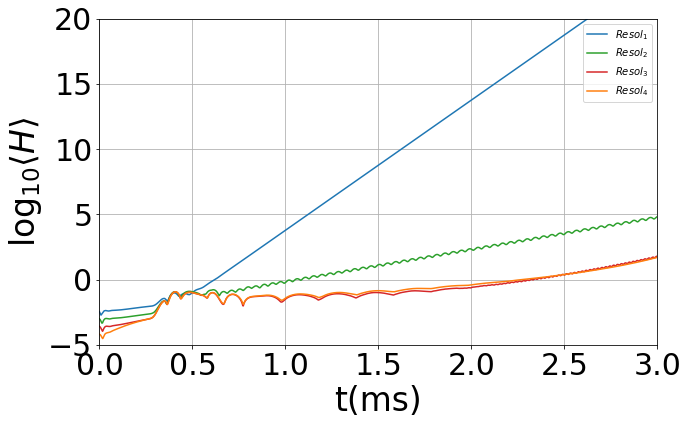

In [1591]:
plt.figure(figsize=(10,6))

plt.grid()
plt.plot(t_50, log_H50, label=r"$Resol_1$", color='C0')
plt.plot(t_100, log_H100, label=r"$Resol_2$", color='C2')
plt.plot(t_200, log_H200, label=r"$Resol_3$", color='C3')
plt.plot(t_400, log_H400, label=r"$Resol_4$", color="C1")
ax = plt.gca()
plt.ylim(-5,20)
plt.xlim(0,3)
ax.set_xlabel('t(ms)', fontsize=33)
ax.set_ylabel(r'$\log_{10}\langle H \rangle$', fontsize=33) 
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=10)

#plt.savefig('Hamilt_resol.pdf',bbox_inches='tight')

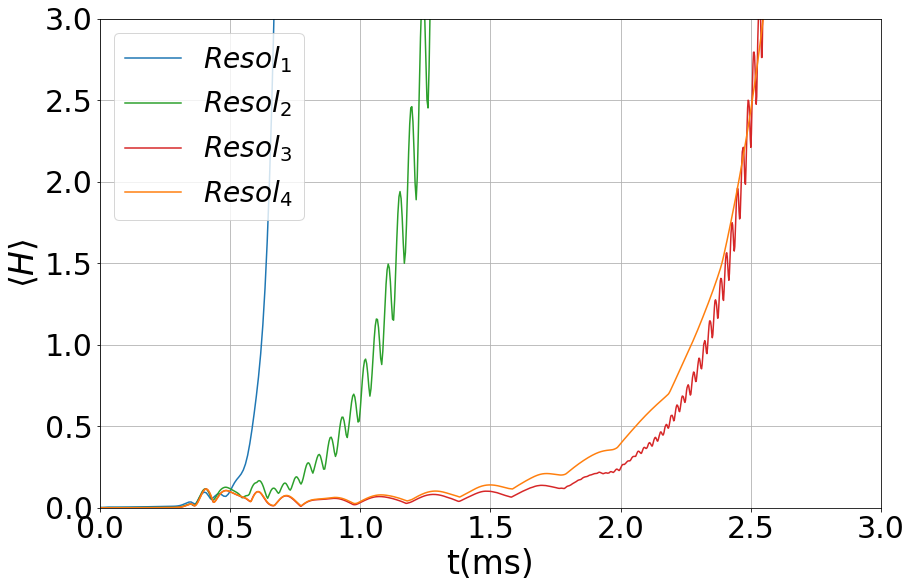

In [1577]:
plt.figure(figsize=(14,9))

plt.grid()
plt.plot(t_50, LnormH_50, label=r"$Resol_1$", color='C0')
plt.plot(t_100, LnormH_100, label=r"$Resol_2$", color='C2')
plt.plot(t_200, LnormH_200, label=r"$Resol_3$", color='C3')
plt.plot(t_400, LnormH_400, label=r"$Resol_4$", color="C1")
ax = plt.gca()
plt.ylim(0,3)
plt.xlim(0,3)
ax.set_xlabel('t(ms)', fontsize=33)
ax.set_ylabel(r'$\langle H \rangle$', fontsize=33) 
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=28)

#plt.savefig('H_resol.pdf',bbox_inches='tight')

# DFT ANALYSIS

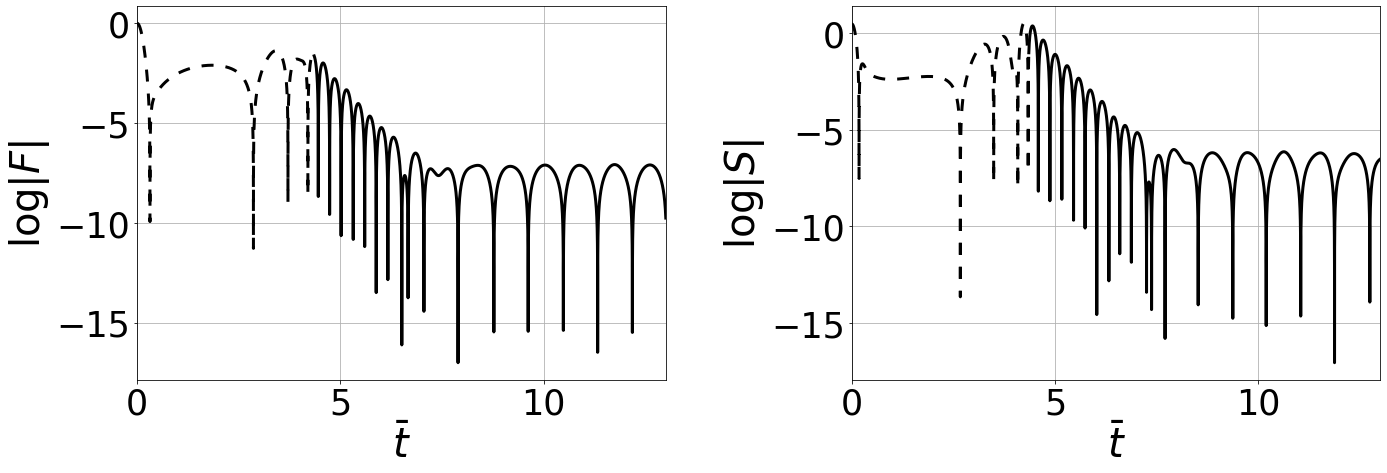

In [1393]:
%matplotlib inline 
t = []
log_S = []
log_F = []

for i in range(len(Sobs400)):
    t.append(dt + i*dt)
    log_S.append(math.log(abs(Sobs400[i])))
    log_F.append(math.log(abs(Fobs400[i])))
    
linhas_pontilhada = (4,4)

fig, axes = plt.subplots(ncols=8, figsize=(18,12))
fig.tight_layout()


plt.subplot(2,2,1)
plt.plot(t[:20000], log_F[:20000], color="Black", dashes=linhas_pontilhada, linewidth=3)
plt.plot(t[20001:], log_F[20001:], color="Black", linewidth=3)
plt.xlim(0,13)
#plt.ylim(-13,0.8)
plt.xlabel(r"$\bar{t}$", fontsize=40)
plt.ylabel(r"$\log|F|$", fontsize=40)
plt.tick_params(axis='both', labelsize=35)
plt.grid()

plt.subplot(2,2,2)
plt.plot(t[:20000], log_S[:20000], color="Black", dashes=linhas_pontilhada, linewidth=3)
plt.plot(t[20001:], log_S[20001:], color="Black", linewidth=3)
plt.xlim(0,13)
#plt.ylim(-13,0.8)
plt.xlabel(r"$\bar{t}$", fontsize=40)
plt.ylabel(r"$\log|S|$", fontsize=40)
plt.tick_params(axis='both', labelsize=35)
plt.grid()


#plt.savefig("logFS.pdf", bbox_inches='tight')

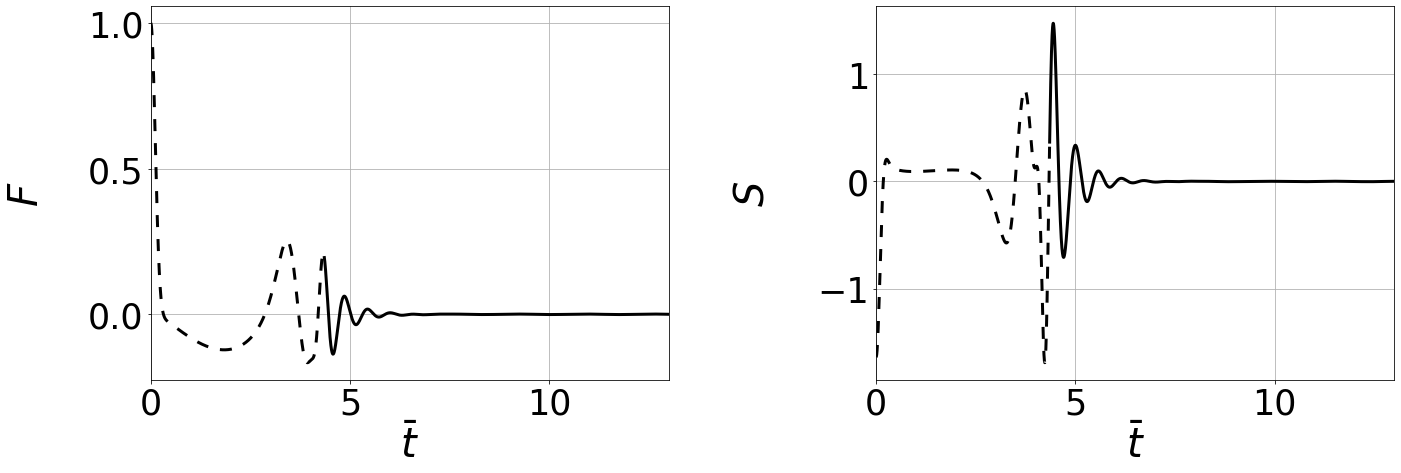

In [1129]:
fig, axes = plt.subplots(ncols=8, figsize=(18,12))
fig.tight_layout()
plt.subplots_adjust(wspace=0.4)

plt.subplot(2,2,1)
plt.plot(t[:20000], Fobs400[:20000], color="Black", dashes=linhas_pontilhada, linewidth=3)
plt.plot(t[20001:], Fobs400[20001:], color="Black", linewidth=3)
plt.xlim(0,13)
#plt.ylim(-12,0.8)
plt.xlabel(r"$\bar{t}$", fontsize=40)
plt.ylabel(r"$F$", fontsize=40)
plt.tick_params(axis='both', labelsize=35)
plt.grid()
plt.gca().yaxis.set_label_coords(-0.2, 0.5)

plt.subplot(2,2,2)
plt.plot(t[:20000], Sobs400[:20000], color="Black", dashes=linhas_pontilhada, linewidth=3)
plt.plot(t[20001:], Sobs400[20001:], color="Black", linewidth=3)
plt.xlim(0,13)
#plt.ylim(-19,0)
plt.xlabel(r"$\bar{t}$", fontsize=40)
plt.ylabel(r"$S$", fontsize=40)
plt.tick_params(axis='both', labelsize=35)
plt.grid()
plt.gca().yaxis.set_label_coords(-0.2, 0.5)

#plt.savefig("FS.pdf", bbox_inches='tight')

In [955]:
def DFT(f):
    """
    Function to calculate the 
    discrete Fourier Transform 
    of a 1D real-valued signal x
    Input
    ----------
    f: array with Psi in r_obs at fixed time
    ----------
    Output
    -------
    X: DFT of f
    """

    N = len(f)
    n = np.arange(N)
    k = n.reshape((N, 1))
    e = np.exp(-2j * np.pi * k * n / N)
    
    X = np.dot(e, f)
    
    return X, n

(0.0, 35.0)

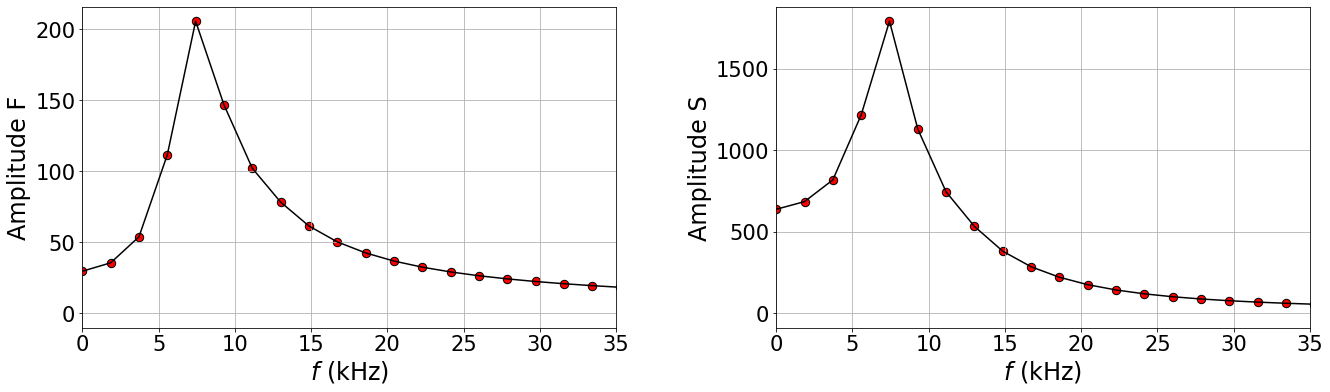

In [1193]:
%matplotlib inline

X_F, n_F = DFT(Fobs400[20000:30500])
X_S, n_S = DFT(Sobs400[20000:30500])

ntobs = len(X_F)

correcao_f = math.sqrt(NewtonG*rho_dim)/(1000) 

T = ntobs * dt400
freq_F = (n_F/T)*correcao_f
freq_S = (n_S/T)*correcao_f

fig = plt.subplots(figsize = (22, 13))
plt.subplots_adjust(wspace=0.3)

plt.subplot(2,2,1)
plt.xlabel(r"$f$ (kHz)", fontsize=24)
plt.plot(freq_F, abs(X_F), color='black')
plt.ylabel('Amplitude F', fontsize=24)
plt.tick_params(axis='both', labelsize=21)
plt.grid()
plt.scatter(freq_F, abs(X_F), s=70, c='red', edgecolors='k')
plt.xlim(0,35)
#plt.ylim(5,45)

plt.subplot(2,2,2)
plt.xlabel(r"$f$ (kHz)", fontsize=24)
plt.plot(freq_S, abs(X_S), color='black')
plt.ylabel('Amplitude S', fontsize=24)
plt.tick_params(axis='both', labelsize=21)
plt.grid()
plt.scatter(freq_S, abs(X_S), s=70, c='red', edgecolors='k')
plt.xlim(0,35)
#plt.ylim(50,425)

#plt.savefig("DFTENw.pdf",  bbox_inches='tight')

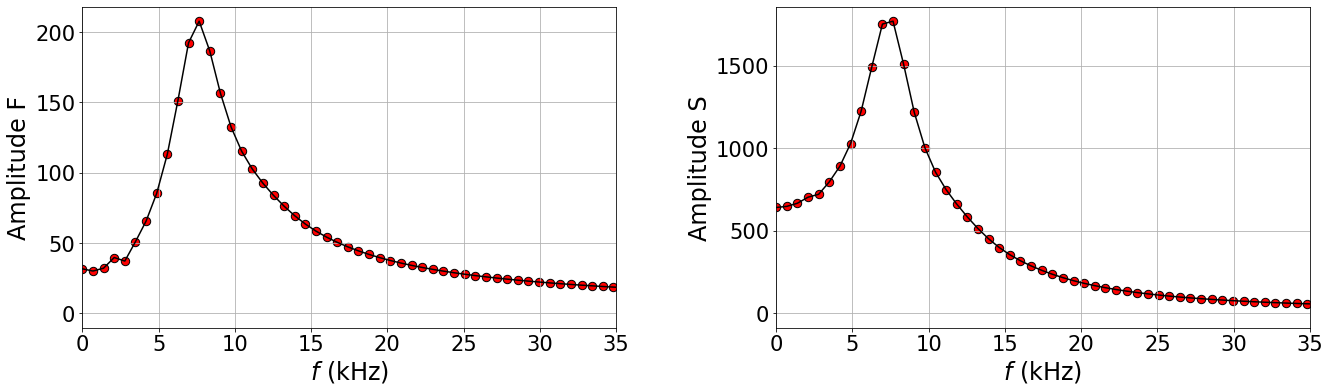

In [1136]:
%matplotlib inline

X_F, n_F = DFT(Fobs400[20000:48000])
X_S, n_S = DFT(Sobs400[20000:48000])

ntobs = len(X_F)

correcao_f = math.sqrt(NewtonG*rho_dim)/(1000) 

T = ntobs * dt400
freq_F = (n_F/T)*correcao_f
freq_S = (n_S/T)*correcao_f

fig = plt.subplots(figsize = (22, 13))
plt.subplots_adjust(wspace=0.3)

plt.subplot(2,2,1)
plt.xlabel(r"$f$ (kHz)", fontsize=24)
plt.plot(freq_F, abs(X_F), color='black')
plt.ylabel('Amplitude F', fontsize=24)
plt.tick_params(axis='both', labelsize=21)
plt.grid()
plt.scatter(freq_F, abs(X_F), s=70, c='red', edgecolors='k')
plt.xlim(0,35)
#plt.ylim(5,45)

plt.subplot(2,2,2)
plt.xlabel(r"$f$ (kHz)", fontsize=24)
plt.plot(freq_S, abs(X_S), color='black')
plt.ylabel('Amplitude S', fontsize=24)
plt.tick_params(axis='both', labelsize=21)
plt.grid()
plt.scatter(freq_S, abs(X_S), s=70, c='red', edgecolors='k')
plt.xlim(0,35)
#plt.ylim(50,425)

plt.savefig("DFTEN.pdf",  bbox_inches='tight')

In [1194]:
absX_F = abs(X_F).tolist()
absX_F_half = absX_F[:int(len(absX_F)/2)]
max_F_y = max(absX_F_half)

indice_F_y = absX_F.index(max_F_y)

freq_F[indice_F_y]

7.429567627407366

In [1195]:
absX_F = abs(X_F).tolist()
absX_F_half = absX_F[:int(len(absX_F)/2)]
max_F_y = max(absX_F_half)

indice_F_y = absX_F.index(max_F_y)

freq_F[indice_F_y]

7.429567627407366

## Fit para 1 componente

In [1165]:
Fobs400list = Fobs400.ravel().tolist()
Sobs400list = Sobs400.ravel().tolist()

Valor ajustado para omega: 47.155976415322954
Frequência correspondente (f): 7.505106742823483
Tempo de decaimento da onda: 0.09711407102942084


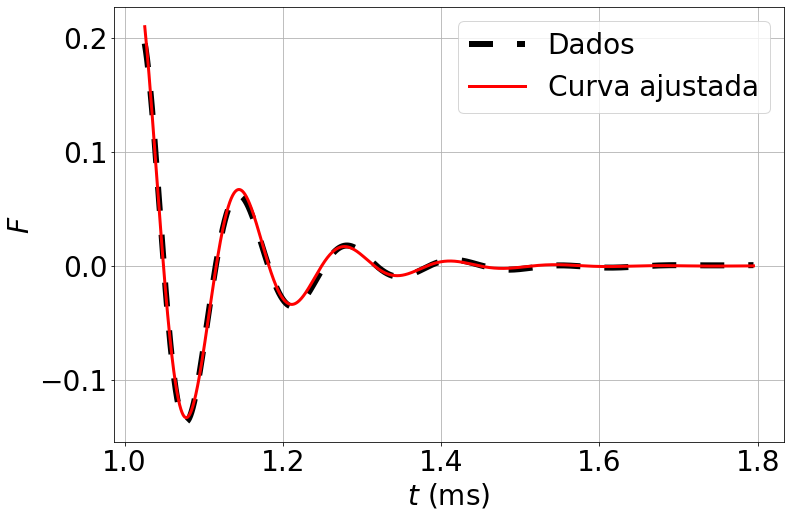

<Figure size 432x288 with 0 Axes>

In [1201]:
%matplotlib inline

from scipy.optimize import curve_fit

def wave_function(t, A, beta, omega, delta):
    return A * np.exp(-beta * t) * np.cos(omega * t + delta)

jin = 20000
jf = 35000
Psi = np.array(np.array(Fobs400list[jin:jf]))

ti = t[jin]* 1000/((NewtonG * rho_dim) ** (1 / 2) ) 
tf = t[jf]* 1000/((NewtonG * rho_dim) ** (1 / 2) ) 

t2 = np.linspace(ti,tf,len(Psi))

fit_params, fit_covariance = curve_fit(wave_function, t2, Psi)

A_fit, beta_fit, omega_fit, delta_fit = fit_params

f = omega_fit / (2 * np.pi)

t_bar = np.linspace(t[jin],t[jf],len(Psi))

print("Valor ajustado para omega:", omega_fit)
print("Frequência correspondente (f):", f)
print("Tempo de decaimento da onda:", 1/beta_fit)
fig = plt.figure(figsize=(12,8))
plt.plot(t2, Psi ,color='Black',label='Dados',dashes=linhas_pontilhada, linewidth=6)
plt.plot(t2, wave_function(t2, *fit_params), 'r',label='Curva ajustada', linewidth=3)
plt.xlabel(r"$t \ $(ms)", fontsize=28)
plt.ylabel(r"$F$", fontsize=28)
plt.tick_params(axis='both', labelsize=28)
plt.grid()
plt.legend(fontsize=28)
plt.show()

#plt.savefig("FitF.png", bbox_inches='tight')

Valor ajustado para omega: 48.43763949730554
Frequência correspondente (f): 7.709089757699405
Tempo de decaimento da onda: 0.09583564110159108


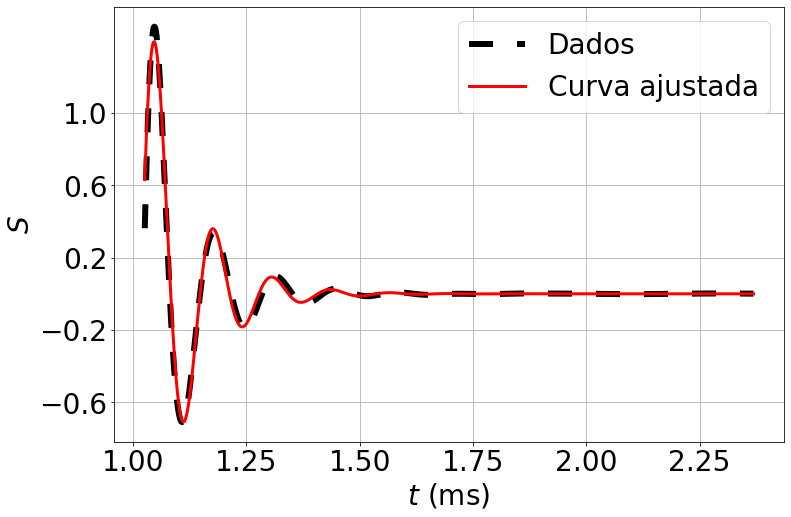

In [1267]:
%matplotlib inline

from scipy.optimize import curve_fit

def wave_function(t, A, beta, omega, delta):
    return A * np.exp(-beta * t) * np.cos(omega * t + delta)

#jin = 20000
#jf = 50000
jin = 20000
jf = 46200
Psi = np.array(Sobs400list[jin:jf])

ti = t[jin]* 1000 / (math.sqrt(NewtonG * rho_dim))
tf = t[jf]* 1000 / (math.sqrt(NewtonG * rho_dim))

t2 = np.linspace(ti,tf,len(Psi))

fit_params, fit_covariance = curve_fit(wave_function, t2, Psi)

A_fit, beta_fit, omega_fit, delta_fit = fit_params

f = omega_fit / (2 * np.pi)

t_bar = np.linspace(t[jin],t[jf],len(Psi))

print("Valor ajustado para omega:", omega_fit)
print("Frequência correspondente (f):", f)
print("Tempo de decaimento da onda:", 1/beta_fit)
fig = plt.figure(figsize=(12,8))
plt.plot(t2, Psi ,color='Black',label='Dados',dashes=linhas_pontilhada, linewidth=6)
plt.plot(t2, wave_function(t2, *fit_params), 'r',label='Curva ajustada', linewidth=3)
plt.xlabel(r"$t \ $(ms)", fontsize=28)
plt.ylabel(r"$S$", fontsize=28)
plt.tick_params(axis='both', labelsize=28)
plt.grid()
#plt.xlim(1.01,1.5)
plt.legend(fontsize=28)
plt.yticks(fontsize=28, ticks=np.arange(-0.6, 1.1, 0.4))
plt.show()

#plt.savefig("FitS.png", bbox_inches='tight')

## Fit para 2 componentes

Valor ajustado para omega2: 2.382080318971011
Frequência correspondente (f2): 0.3791198576061552


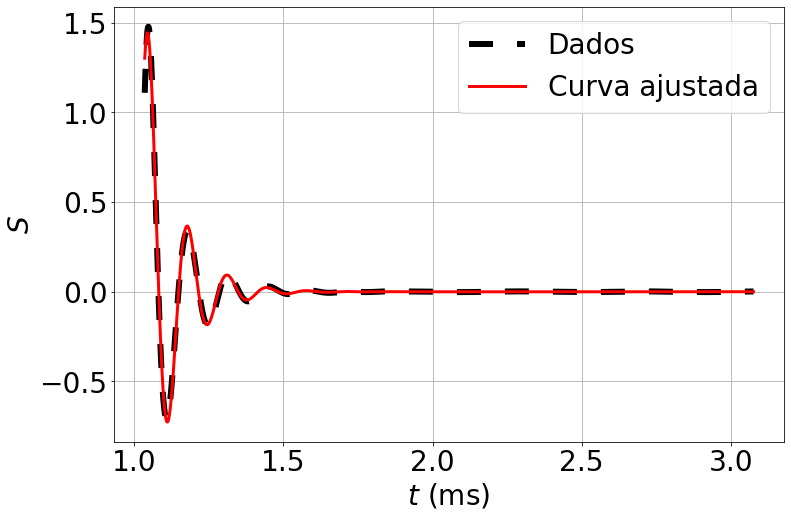

In [1528]:
%matplotlib inline

from scipy.optimize import curve_fit

def wave_function(t, A1, delta1, A2, omega2, delta2):
    #return A * np.exp(-beta * t) * np.cos(omega * t + delta)
    return A1 * np.exp(-t/0.09711407102942084) * np.cos(47.155976415322954 * t + delta1) + A2 * np.cos(omega2 * t + delta2)

#jin = 15000
#jf = 59700
#jin = 18500
#jf = 59700
#jin = 23700
#jf = 59700
#jin = 22620
#jf = 60000
jin = 20180
jf = 60000

Psi = np.array(Sobs400list[jin:jf])

ti = t[jin]* 1000/((NewtonG * rho_dim) ** (1 / 2) ) 
tf = t[jf]* 1000/((NewtonG * rho_dim) ** (1 / 2) ) 
                  
t2 = np.linspace(ti,tf,len(Psi))

fit_params, fit_covariance = curve_fit(wave_function, t2, Psi)

A1_fit, delta1_fit, A2_fit, omega2_fit, delta2_fit = fit_params

f2 = omega2_fit / (2 * np.pi)

print("Valor ajustado para omega2:", omega2_fit)
print("Frequência correspondente (f2):", f2)
fig = plt.figure(figsize=(12,8))
plt.plot(t2, Psi ,color='Black',label='Dados',dashes=linhas_pontilhada, linewidth=6)
plt.plot(t2, wave_function(t2, *fit_params), 'r',label='Curva ajustada', linewidth=3)
plt.xlabel(r"$t \ $(ms)", fontsize=28)
plt.ylabel(r"$S$", fontsize=28)
plt.tick_params(axis='both', labelsize=28)
plt.grid()
#plt.xlim(190,300)
plt.legend(fontsize=28)
plt.show()